<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip


--2024-11-22 11:27:23--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.105.241, 54.231.136.121, 52.216.241.36, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.105.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  73.7MB/s    in 3m 27s  

2024-11-22 11:30:50 (88.9 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2024-11-22 11:30:50--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.24.143, 54.231.170.57, 52.217.225.249, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.24.143|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[=========

In [2]:
from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)

        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)

    except BadZipFile as e:
        print("Error:", e)


extract_ANN_path = "/content/coco_ann2017"
extract_VAL_path = "/content/coco_val2017"
extract_Train_path = "/content/coco_train2017"

extract_zip_file(extract_Train_path)
extract_zip_file(extract_VAL_path)
extract_zip_file(extract_ANN_path)


In [ ]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [3]:
!pip install pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.3 MB/s eta 0:00:00


In [27]:
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection
import pytorch_lightning as pl
import torch

# Define id2label and label2id for your dataset (COCO classes)
id2label = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 12: "stop sign", 13: "parking meter", 14: "bench",
    15: "bird", 16: "cat", 17: "dog", 18: "horse", 19: "sheep", 20: "cow",
    21: "elephant", 22: "bear", 23: "zebra", 24: "giraffe", 25: "hat",
    26: "backpack", 27: "umbrella", 28: "handbag", 29: "tie", 30: "suitcase",
    31: "frisbee", 32: "skis", 33: "snowboard", 34: "sports ball", 35: "kite",
    36: "baseball bat", 37: "baseball glove", 38: "skateboard", 39: "surfboard",
    40: "tennis racket", 41: "bottle", 42: "wine glass", 43: "cup", 44: "fork",
    45: "knife", 46: "spoon", 47: "bowl", 48: "banana", 49: "apple", 50: "sandwich",
    51: "orange", 52: "broccoli", 53: "carrot", 54: "hot dog", 55: "pizza",
    56: "donut", 57: "cake", 58: "chair", 59: "couch", 60: "potted plant",
    61: "bed", 62: "dining table", 63: "toilet", 64: "tv", 65: "laptop",
    66: "mouse", 67: "remote", 68: "keyboard", 69: "cell phone", 70: "microwave",
    71: "oven", 72: "toaster", 73: "sink", 74: "refrigerator", 75: "book",
    76: "clock", 77: "vase", 78: "scissors", 79: "teddy bear", 80: "hair drier"
}

label2id = {v: k for k, v in id2label.items()}

# Initialize processor for DETR
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Define dataset paths
train_dataset = CocoDetection(
    root='/content/coco_train2017/train2017',
    annFile='/content/coco_ann2017/annotations/instances_train2017.json'
)
val_dataset = CocoDetection(
    root='/content/coco_val2017/val2017',
    annFile='/content/coco_ann2017/annotations/instances_val2017.json'
)

# Transform for converting PIL images to tensors
to_tensor = ToTensor()

# Define collate_fn
# Define collate_fn
def collate_fn(batch):
    pixel_values = [to_tensor(item[0]) for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")

    labels = []
    for idx, item in enumerate(batch):
        target = item[1]
        boxes = []
        class_labels = []

        for ann in target:
            class_id = ann['category_id']
            if class_id <= 80:
                boxes.append(ann['bbox'])
                class_labels.append(class_id)

        # Ensure `boxes` has shape `(num_boxes, 4)`
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes = torch.empty((0, 4), dtype=torch.float32)  # Empty tensor with 2D shape

        class_labels = torch.tensor(class_labels, dtype=torch.int64) if class_labels else torch.empty(0, dtype=torch.int64)

        labels.append({
            "class_labels": class_labels,
            "boxes": boxes,
            "image_id": torch.tensor([idx]),  # Example ID
        })

    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }




# Create dataloaders
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)

# Model class using PyTorch Lightning
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay, id2label, label2id):
         super().__init__()
         self.model = DetrForObjectDetection.from_pretrained(
             "facebook/detr-resnet-50",
             num_labels=len(id2label),
             id2label=id2label,
             label2id=label2id,
             ignore_mismatched_sizes=True
         )
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
         return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

     def common_step(self, batch, batch_idx):
         pixel_values = batch["pixel_values"]
         pixel_mask = batch["pixel_mask"]

         labels = []
         for item in batch["labels"]:
          labels_dict = {k: v.to(self.device) for k, v in item.items()}
          labels_dict["class_labels"] = labels_dict["class_labels"].to(torch.int64)  # Ensure correct type
          labels_dict["boxes"] = labels_dict["boxes"].to(torch.float32)  # Ensure correct type
          labels.append(labels_dict)

    # Forward pass
         outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

         loss = outputs.loss
         loss_dict = outputs.loss_dict

         return loss, loss_dict


     def training_step(self, batch, batch_idx):
         loss, loss_dict = self.common_step(batch, batch_idx)
         self.log("training_loss", loss)  # Log the total loss

    # Log each individual loss component from loss_dict
         for k, v in loss_dict.items():
          self.log(f"train_{k}", v.item())

         return loss

     def validation_step(self, batch, batch_idx):
         loss, loss_dict = self.common_step(batch, batch_idx)
         self.log("validation_loss", loss)
         for k, v in loss_dict.items():
             self.log(f"validation_{k}", v.item())

         return loss

     def configure_optimizers(self):
         param_dicts = [
             {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
             {
                 "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                 "lr": self.lr_backbone,
             },
         ]
         optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
         return optimizer

     def train_dataloader(self):
         return train_dataloader

     def val_dataloader(self):
         return val_dataloader

# Initialize the model
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, id2label=id2label, label2id=label2id)

# Initialize the Trainer
from pytorch_lightning import Trainer
trainer = Trainer(max_steps=10000 ,gradient_clip_val=0.1)
trainer.fit(model)


loading annotations into memory...
Done (t=20.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10000` reached.


In [29]:
torch.save(model.state_dict(), "detr_finetuned.pth")


<ipython-input-38-3609b01a9c30>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/detr_finetuned.pth'))  # Load your fine-tuned mod

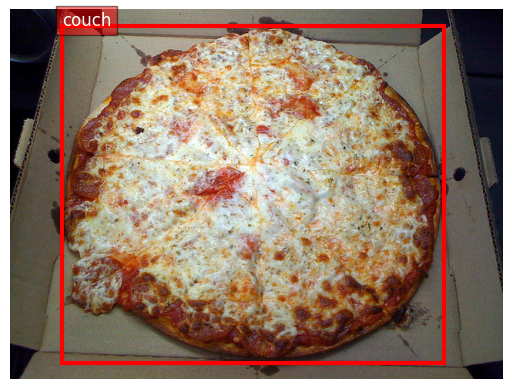

In [38]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Initialize the image processor and model (make sure the model is trained)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.load_state_dict(torch.load('/content/detr_finetuned.pth'))  # Load your fine-tuned model
model.eval()  # Set to evaluation mode

# Define the id2label mapping as provided earlier
id2label = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 12: "stop sign", 13: "parking meter", 14: "bench",
    15: "bird", 16: "cat", 17: "dog", 18: "horse", 19: "sheep", 20: "cow",
    21: "elephant", 22: "bear", 23: "zebra", 24: "giraffe", 25: "hat",
    26: "backpack", 27: "umbrella", 28: "handbag", 29: "tie", 30: "suitcase",
    31: "frisbee", 32: "skis", 33: "snowboard", 34: "sports ball", 35: "kite",
    36: "baseball bat", 37: "baseball glove", 38: "skateboard", 39: "surfboard",
    40: "tennis racket", 41: "bottle", 42: "wine glass", 43: "cup", 44: "fork",
    45: "knife", 46: "spoon", 47: "bowl", 48: "banana", 49: "apple", 50: "sandwich",
    51: "orange", 52: "broccoli", 53: "carrot", 54: "hot dog", 55: "pizza",
    56: "donut", 57: "cake", 58: "chair", 59: "couch", 60: "potted plant",
    61: "bed", 62: "dining table", 63: "toilet", 64: "tv", 65: "laptop",
    66: "mouse", 67: "remote", 68: "keyboard", 69: "cell phone", 70: "microwave",
    71: "oven", 72: "toaster", 73: "sink", 74: "refrigerator", 75: "book",
    76: "clock", 77: "vase", 78: "scissors", 79: "teddy bear", 80: "hair drier"
}

# Define the function to make predictions on an image
def predict(image_path, threshold=0.5):
    # Load the image
    image = Image.open(image_path)

    # Preprocess the image using the processor
    inputs = processor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted labels and bounding boxes
    target_sizes = torch.tensor([image.size[::-1]])  # Convert (width, height) format
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

    # Display the image with bounding boxes and class names
    plt.imshow(image)
    ax = plt.gca()

    # Loop through the results and draw bounding boxes with predicted class names
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.tolist()

            # Check if the label exceeds 80, and if so, set it to "unknown"
            class_name = id2label[label.item()] if label.item() <= 80 else "unknown"

            ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color="red", linewidth=3))
            ax.text(x_min, y_min, class_name, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Example usage
image_path = "/content/coco_val2017/val2017/000000024144.jpg"
predict(image_path)


In [40]:
# Iterate over images in the val2017 folder
for image_name in os.listdir(image_folder):
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, image_name)
        image = Image.open(img_path)

        # Convert image to RGB if it is not already in that format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted labels, scores, and boxes
        target_sizes = torch.tensor([image.size[::-1]])  # Convert (width, height) format
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

        # Extract predicted bounding boxes, scores, and labels
        pred_boxes = results["boxes"].cpu().numpy()  # [x_min, y_min, x_max, y_max]
        pred_scores = results["scores"].cpu().numpy()
        pred_labels = results["labels"].cpu().numpy()

        # Get ground truth annotations for the current image
        image_id = file_name_to_image_id[image_name]
        ground_truths = image_id_to_annotations.get(image_id, [])

        # Convert ground truth bounding boxes from [x, y, width, height] to [x_min, y_min, x_max, y_max]
        ground_truth_boxes = []
        for gt in ground_truths:
            x, y, w, h = gt['bbox']
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            ground_truth_boxes.append([x_min, y_min, x_max, y_max])
        ground_truth_boxes = torch.tensor(ground_truth_boxes, dtype=torch.float32)

        # Skip IoU calculation if there are no ground truth boxes
        if ground_truth_boxes.size(0) == 0:
            false_positives += len(pred_boxes)  # All predictions are false positives
            continue

        # Match predictions to ground truths using IoU
        gt_matched = [False] * len(ground_truth_boxes)  # Track matched ground truths
        for i, pred_box in enumerate(pred_boxes):
            if pred_scores[i] >= 0.5:  # Confidence threshold
                pred_tensor = torch.tensor([pred_box], dtype=torch.float32)  # Convert to 2D tensor
                ious = box_iou(pred_tensor, ground_truth_boxes)  # Calculate IoUs
                max_iou, max_iou_idx = torch.max(ious, dim=1)  # Get the best match
                if max_iou.item() >= iou_threshold:  # If IoU >= threshold, it's a match
                    if not gt_matched[max_iou_idx.item()]:  # True Positive if not matched before
                        true_positives += 1
                        gt_matched[max_iou_idx.item()] = True
                    else:
                        false_positives += 1  # Duplicate match
                else:
                    false_positives += 1  # IoU < threshold

        # Count remaining unmatched ground truths as False Negatives
        false_negatives += gt_matched.count(False)

# Calculate precision, recall, and F1-score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print("Evaluation Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"True Positives: {true_positives}, False Positives: {false_positives}, False Negatives: {false_negatives}")


Evaluation Results:
Precision: 0.4604
Recall: 0.7179
F1-Score: 0.5610
True Positives: 30128, False Positives: 35309, False Negatives: 11841


In [12]:
# Specify the directory to save the model
save_directory = "saved_detr_model"

# Save the trained model
model.model.save_pretrained(save_directory)

# Optionally, save the processor
processor.save_pretrained(save_directory)

print(f"Model and processor have been saved to {save_directory}")


Model and processor have been saved to saved_detr_model


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


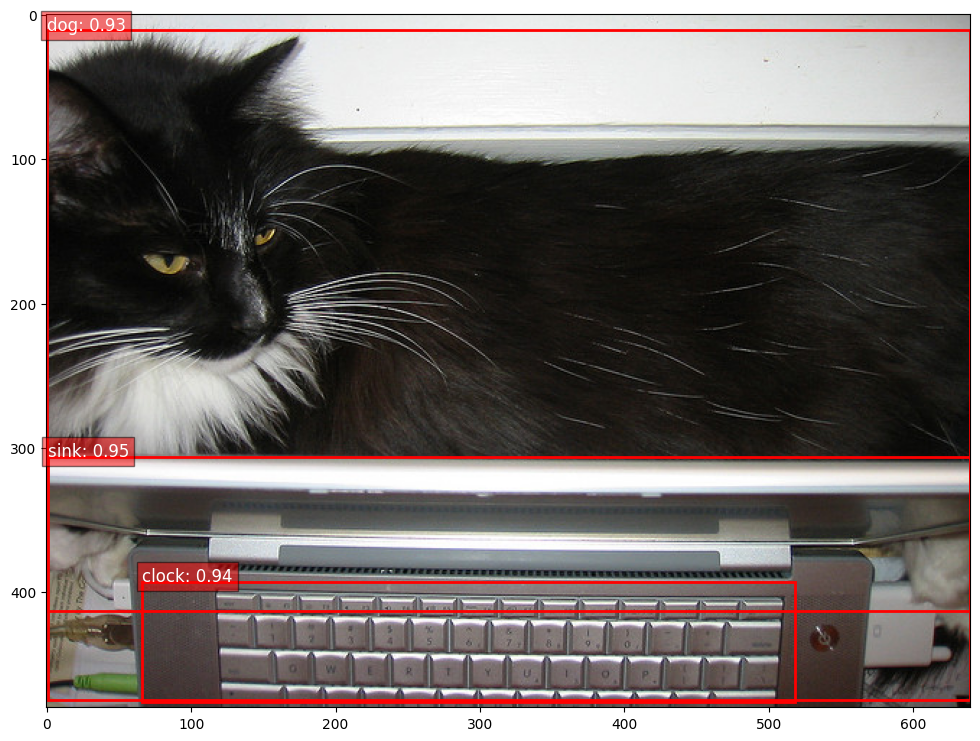

In [5]:
from PIL import Image
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define id2label dictionary
id2label = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 12: "stop sign", 13: "parking meter", 14: "bench",
    15: "bird", 16: "cat", 17: "dog", 18: "horse", 19: "sheep", 20: "cow",
    21: "elephant", 22: "bear", 23: "zebra", 24: "giraffe", 25: "hat",
    26: "backpack", 27: "umbrella", 28: "handbag", 29: "tie", 30: "suitcase",
    31: "frisbee", 32: "skis", 33: "snowboard", 34: "sports ball", 35: "kite",
    36: "baseball bat", 37: "baseball glove", 38: "skateboard", 39: "surfboard",
    40: "tennis racket", 41: "bottle", 42: "wine glass", 43: "cup", 44: "fork",
    45: "knife", 46: "spoon", 47: "bowl", 48: "banana", 49: "apple", 50: "sandwich",
    51: "orange", 52: "broccoli", 53: "carrot", 54: "hot dog", 55: "pizza",
    56: "donut", 57: "cake", 58: "chair", 59: "couch", 60: "potted plant",
    61: "bed", 62: "dining table", 63: "toilet", 64: "tv", 65: "laptop",
    66: "mouse", 67: "remote", 68: "keyboard", 69: "cell phone", 70: "microwave",
    71: "oven", 72: "toaster", 73: "sink", 74: "refrigerator", 75: "book",
    76: "clock", 77: "vase", 78: "scissors", 79: "teddy bear", 80: "hair drier",
    81: "toothbrush"
}

# Load the image (use an image URL or local path)
image_path = "/content/coco_val2017/val2017/000000001675.jpg"
image = Image.open(image_path)

# Initialize the image processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Load the pre-trained DETR model for object detection
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():  # Disable gradients during inference
    outputs = model(**inputs)

# Post-process the outputs to extract the top predictions
results = processor.post_process_object_detection(
    outputs=outputs,  # Pass the raw model outputs
    target_sizes=[image.size[::-1]],  # Image size in (height, width)
    threshold=0.9  # Confidence threshold
)

# Get the first image results from the batch
result = results[0]

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, figsize=(12, 9))

# Display the image
ax.imshow(image)

# Draw the predicted bounding boxes
for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]  # Convert box coordinates to list
    xmin, ymin, xmax, ymax = box

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the plot
    ax.add_patch(rect)

    # Add label text (use id2label to get the label name)
    label_name = id2label.get(label.item(), "Unknown")  # Fallback to "Unknown" if the label ID is not in the dictionary
    ax.text(
        xmin,
        ymin,
        f"{label_name}: {score.item():.2f}",
        color='white',
        fontsize=12,
        bbox=dict(facecolor='red', alpha=0.5)
    )

# Show the plot
plt.show()


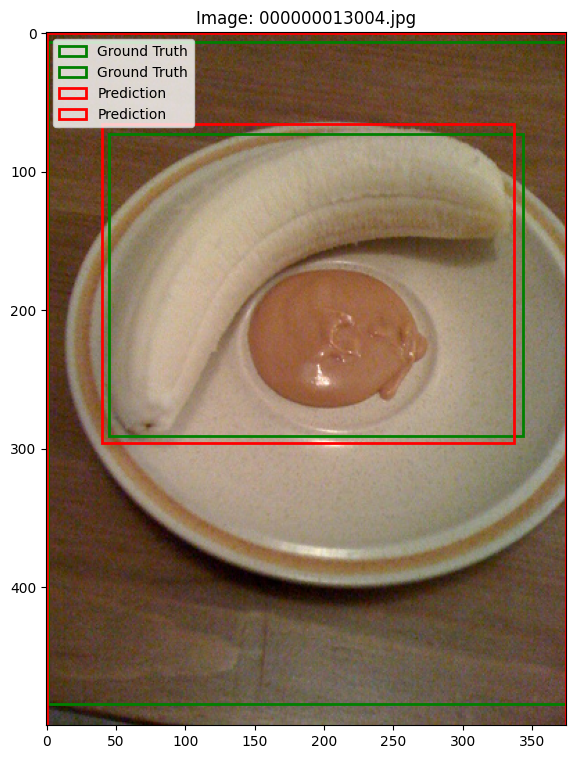

Average IoU for selected images: 0.6485


In [6]:
import json
from PIL import Image  # For loading images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load COCO annotations
with open("/content/coco_ann2017/annotations/instances_val2017.json", "r") as f:
    coco_data = json.load(f)

# Function to compute IoU
def compute_iou(box1, box2):
    """
    Compute the IoU between two bounding boxes.
    box1, box2: [xmin, ymin, xmax, ymax]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Parse ground truth bounding boxes
def get_ground_truth_boxes(image_id, annotations):
    """
    Extract ground truth boxes for a specific image.
    """
    return [
        [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert to [xmin, ymin, xmax, ymax]
        for ann in annotations
        if ann["image_id"] == image_id and ann["iscrowd"] == 0
        for bbox in [ann["bbox"]]
    ]

# Function to evaluate IoU for specific image paths and display them
def evaluate_iou(image_paths, coco_data):
    total_iou = 0
    num_comparisons = 0

    # Create a mapping of image file names to IDs
    image_id_map = {img["file_name"]: img["id"] for img in coco_data["images"]}

    for image_path in image_paths:
        # Extract file name from the path
        file_name = image_path.split("/")[-1]

        # Get the image ID from the mapping
        image_id = image_id_map.get(file_name)
        if image_id is None:
            print(f"Image {file_name} not found in COCO dataset.")
            continue

        # Get ground truth boxes
        gt_boxes = get_ground_truth_boxes(image_id, coco_data["annotations"])

        # Load and process the image
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        results = processor.post_process_object_detection(
            outputs=outputs, target_sizes=[image.size[::-1]], threshold=0.5
        )[0]

        pred_boxes = results["boxes"].tolist()

        # Visualize the image and draw bounding boxes
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)

        # Draw ground truth boxes
        for gt_box in gt_boxes:
            rect = patches.Rectangle(
                (gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth"
            )
            ax.add_patch(rect)

        # Draw predicted boxes
        for pred_box in pred_boxes:
            rect = patches.Rectangle(
                (pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1],
                linewidth=2, edgecolor='r', facecolor='none', label="Prediction"
            )
            ax.add_patch(rect)

        plt.title(f"Image: {file_name}")
        plt.legend(loc="upper left")
        plt.show()

        # Compare each prediction with ground truth
        for pred_box in pred_boxes:
            for gt_box in gt_boxes:
                iou = compute_iou(pred_box, gt_box)
                total_iou += iou
                num_comparisons += 1

    # Calculate average IoU
    average_iou = total_iou / num_comparisons if num_comparisons > 0 else 0
    return average_iou

# List of specific image paths to evaluate
image_paths = [
    "/content/coco_val2017/val2017/000000013004.jpg",
    # Add more image paths as needed
]

# Evaluate IoU for the selected images
average_iou = evaluate_iou(image_paths, coco_data)
print(f"Average IoU for selected images: {average_iou:.4f}")


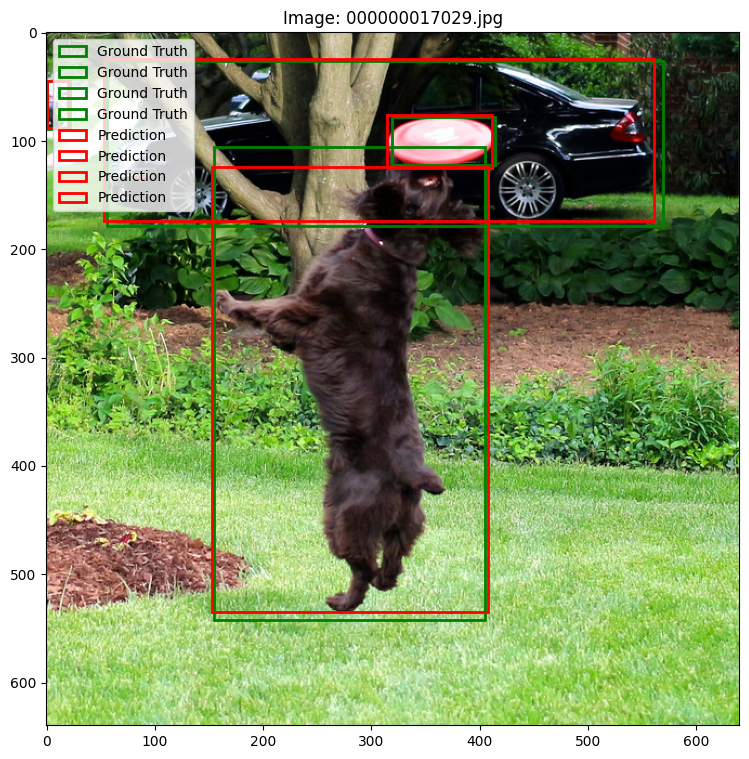

Average IoU for selected images: 0.2432


In [10]:
import json
from PIL import Image  # For loading images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load COCO annotations
with open("/content/coco_ann2017/annotations/instances_val2017.json", "r") as f:
    coco_data = json.load(f)

# Function to compute IoU
def compute_iou(box1, box2):
    """
    Compute the IoU between two bounding boxes.
    box1, box2: [xmin, ymin, xmax, ymax]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Parse ground truth bounding boxes
def get_ground_truth_boxes(image_id, annotations):
    """
    Extract ground truth boxes for a specific image.
    """
    return [
        [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert to [xmin, ymin, xmax, ymax]
        for ann in annotations
        if ann["image_id"] == image_id and ann["iscrowd"] == 0
        for bbox in [ann["bbox"]]
    ]

# Function to evaluate IoU for specific image paths and display them
def evaluate_iou(image_paths, coco_data):
    total_iou = 0
    num_comparisons = 0

    # Create a mapping of image file names to IDs
    image_id_map = {img["file_name"]: img["id"] for img in coco_data["images"]}

    for image_path in image_paths:
        # Extract file name from the path
        file_name = image_path.split("/")[-1]

        # Get the image ID from the mapping
        image_id = image_id_map.get(file_name)
        if image_id is None:
            print(f"Image {file_name} not found in COCO dataset.")
            continue

        # Get ground truth boxes
        gt_boxes = get_ground_truth_boxes(image_id, coco_data["annotations"])

        # Load and process the image
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        results = processor.post_process_object_detection(
            outputs=outputs, target_sizes=[image.size[::-1]], threshold=0.5
        )[0]

        pred_boxes = results["boxes"].tolist()

        # Visualize the image and draw bounding boxes
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)

        # Draw ground truth boxes
        for gt_box in gt_boxes:
            rect = patches.Rectangle(
                (gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth"
            )
            ax.add_patch(rect)

        # Draw predicted boxes
        for pred_box in pred_boxes:
            rect = patches.Rectangle(
                (pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1],
                linewidth=2, edgecolor='r', facecolor='none', label="Prediction"
            )
            ax.add_patch(rect)

        plt.title(f"Image: {file_name}")
        plt.legend(loc="upper left")
        plt.show()

        # Compare each prediction with ground truth
        for pred_box in pred_boxes:
            for gt_box in gt_boxes:
                iou = compute_iou(pred_box, gt_box)
                total_iou += iou
                num_comparisons += 1

    # Calculate average IoU
    average_iou = total_iou / num_comparisons if num_comparisons > 0 else 0
    return average_iou

# List of specific image paths to evaluate
image_paths = [
    "/content/coco_val2017/val2017/000000017029.jpg",
    # Add more image paths as needed
]

# Evaluate IoU for the selected images
average_iou = evaluate_iou(image_paths, coco_data)
print(f"Average IoU for selected images: {average_iou:.4f}")


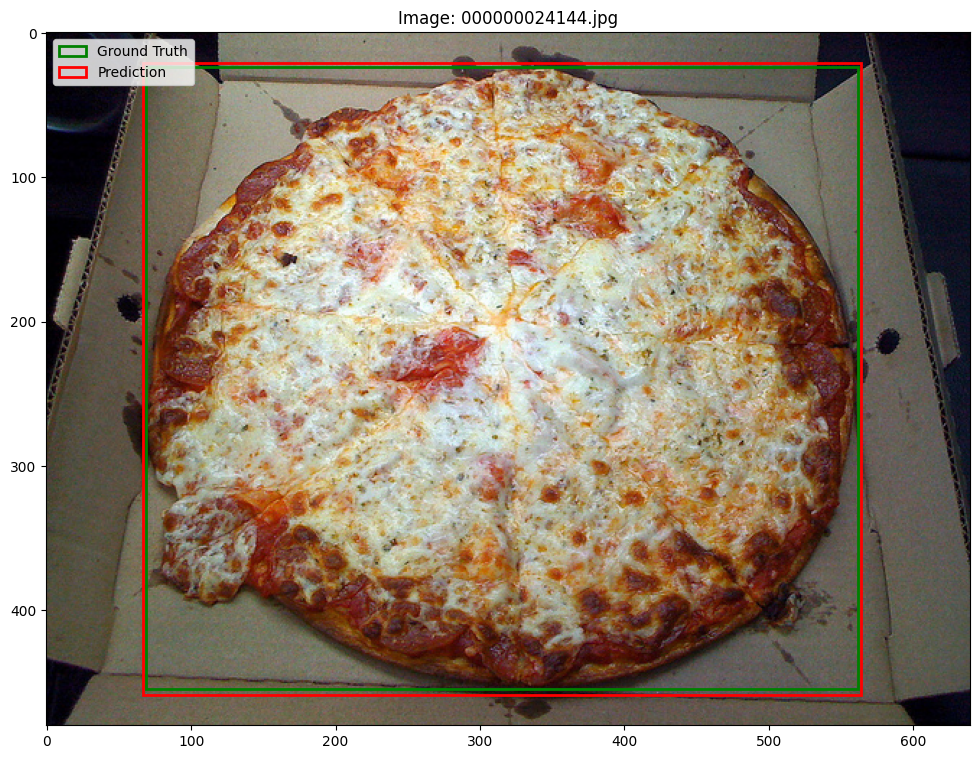

Average IoU for selected images: 0.9765


In [11]:
import json
from PIL import Image  # For loading images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load COCO annotations
with open("/content/coco_ann2017/annotations/instances_val2017.json", "r") as f:
    coco_data = json.load(f)

# Function to compute IoU
def compute_iou(box1, box2):
    """
    Compute the IoU between two bounding boxes.
    box1, box2: [xmin, ymin, xmax, ymax]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Parse ground truth bounding boxes
def get_ground_truth_boxes(image_id, annotations):
    """
    Extract ground truth boxes for a specific image.
    """
    return [
        [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert to [xmin, ymin, xmax, ymax]
        for ann in annotations
        if ann["image_id"] == image_id and ann["iscrowd"] == 0
        for bbox in [ann["bbox"]]
    ]

# Function to evaluate IoU for specific image paths and display them
def evaluate_iou(image_paths, coco_data):
    total_iou = 0
    num_comparisons = 0

    # Create a mapping of image file names to IDs
    image_id_map = {img["file_name"]: img["id"] for img in coco_data["images"]}

    for image_path in image_paths:
        # Extract file name from the path
        file_name = image_path.split("/")[-1]

        # Get the image ID from the mapping
        image_id = image_id_map.get(file_name)
        if image_id is None:
            print(f"Image {file_name} not found in COCO dataset.")
            continue

        # Get ground truth boxes
        gt_boxes = get_ground_truth_boxes(image_id, coco_data["annotations"])

        # Load and process the image
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        results = processor.post_process_object_detection(
            outputs=outputs, target_sizes=[image.size[::-1]], threshold=0.5
        )[0]

        pred_boxes = results["boxes"].tolist()

        # Visualize the image and draw bounding boxes
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)

        # Draw ground truth boxes
        for gt_box in gt_boxes:
            rect = patches.Rectangle(
                (gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth"
            )
            ax.add_patch(rect)

        # Draw predicted boxes
        for pred_box in pred_boxes:
            rect = patches.Rectangle(
                (pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1],
                linewidth=2, edgecolor='r', facecolor='none', label="Prediction"
            )
            ax.add_patch(rect)

        plt.title(f"Image: {file_name}")
        plt.legend(loc="upper left")
        plt.show()

        # Compare each prediction with ground truth
        for pred_box in pred_boxes:
            for gt_box in gt_boxes:
                iou = compute_iou(pred_box, gt_box)
                total_iou += iou
                num_comparisons += 1

    # Calculate average IoU
    average_iou = total_iou / num_comparisons if num_comparisons > 0 else 0
    return average_iou

# List of specific image paths to evaluate
image_paths = [
    "/content/coco_val2017/val2017/000000024144.jpg",
    # Add more image paths as needed
]

# Evaluate IoU for the selected images
average_iou = evaluate_iou(image_paths, coco_data)
print(f"Average IoU for selected images: {average_iou:.4f}")


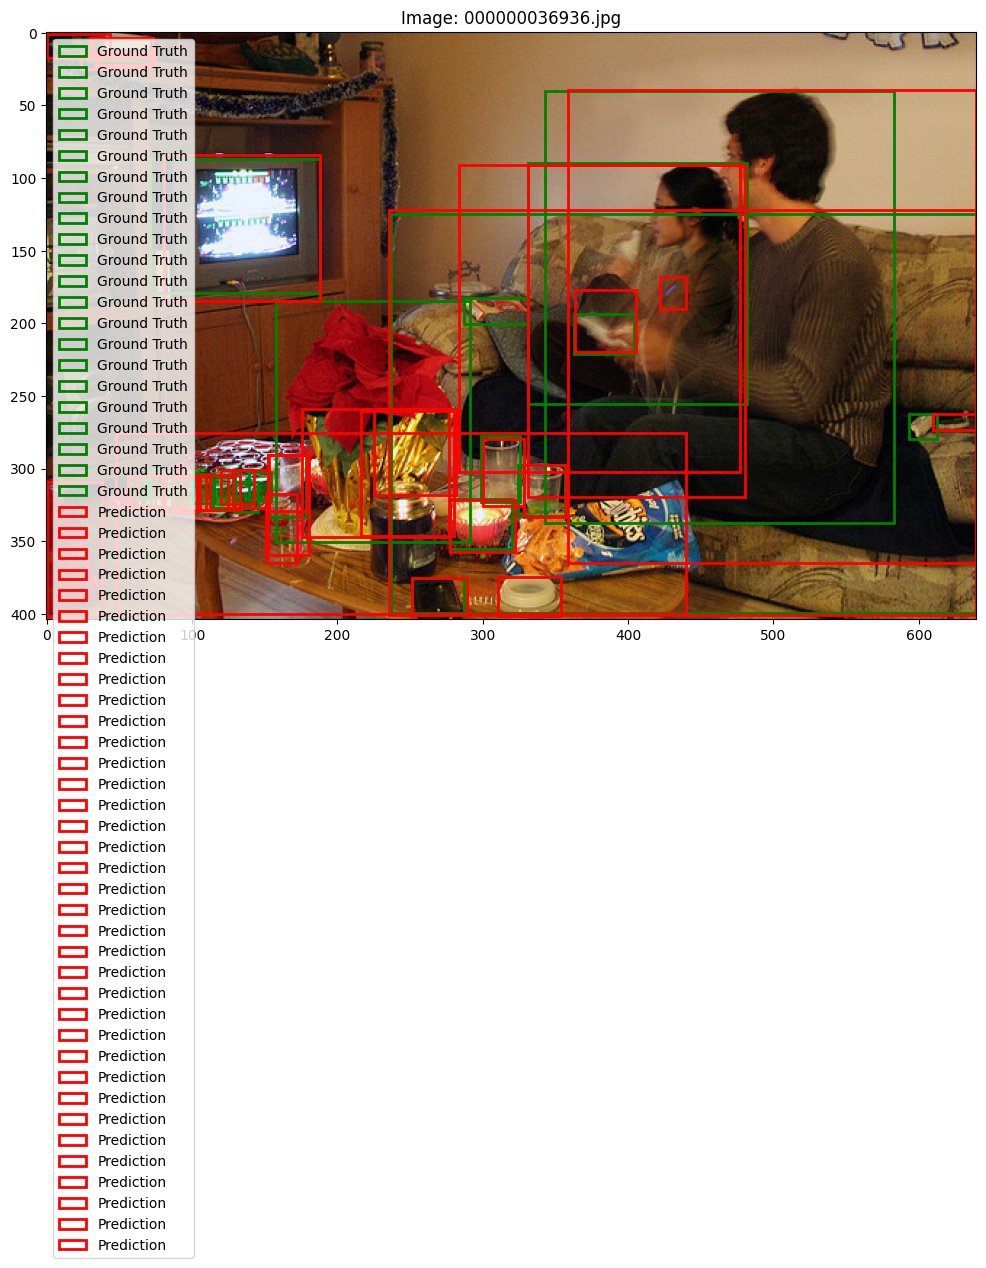

Average IoU for selected images: 0.0304


In [8]:
import json
from PIL import Image  # For loading images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load COCO annotations
with open("/content/coco_ann2017/annotations/instances_val2017.json", "r") as f:
    coco_data = json.load(f)

# Function to compute IoU
def compute_iou(box1, box2):
    """
    Compute the IoU between two bounding boxes.
    box1, box2: [xmin, ymin, xmax, ymax]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Parse ground truth bounding boxes
def get_ground_truth_boxes(image_id, annotations):
    """
    Extract ground truth boxes for a specific image.
    """
    return [
        [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert to [xmin, ymin, xmax, ymax]
        for ann in annotations
        if ann["image_id"] == image_id and ann["iscrowd"] == 0
        for bbox in [ann["bbox"]]
    ]

# Function to evaluate IoU for specific image paths and display them
def evaluate_iou(image_paths, coco_data):
    total_iou = 0
    num_comparisons = 0

    # Create a mapping of image file names to IDs
    image_id_map = {img["file_name"]: img["id"] for img in coco_data["images"]}

    for image_path in image_paths:
        # Extract file name from the path
        file_name = image_path.split("/")[-1]

        # Get the image ID from the mapping
        image_id = image_id_map.get(file_name)
        if image_id is None:
            print(f"Image {file_name} not found in COCO dataset.")
            continue

        # Get ground truth boxes
        gt_boxes = get_ground_truth_boxes(image_id, coco_data["annotations"])

        # Load and process the image
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        results = processor.post_process_object_detection(
            outputs=outputs, target_sizes=[image.size[::-1]], threshold=0.5
        )[0]

        pred_boxes = results["boxes"].tolist()

        # Visualize the image and draw bounding boxes
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)

        # Draw ground truth boxes
        for gt_box in gt_boxes:
            rect = patches.Rectangle(
                (gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth"
            )
            ax.add_patch(rect)

        # Draw predicted boxes
        for pred_box in pred_boxes:
            rect = patches.Rectangle(
                (pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1],
                linewidth=2, edgecolor='r', facecolor='none', label="Prediction"
            )
            ax.add_patch(rect)

        plt.title(f"Image: {file_name}")
        plt.legend(loc="upper left")
        plt.show()

        # Compare each prediction with ground truth
        for pred_box in pred_boxes:
            for gt_box in gt_boxes:
                iou = compute_iou(pred_box, gt_box)
                total_iou += iou
                num_comparisons += 1

    # Calculate average IoU
    average_iou = total_iou / num_comparisons if num_comparisons > 0 else 0
    return average_iou

# List of specific image paths to evaluate
image_paths = [
    "/content/coco_val2017/val2017/000000036936.jpg",
    # Add more image paths as needed
]

# Evaluate IoU for the selected images
average_iou = evaluate_iou(image_paths, coco_data)
print(f"Average IoU for selected images: {average_iou:.4f}")


In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class DetrModel(pl.LightningModule):
    def __init__(self, id2label, lr, lr_backbone, weight_decay):
        super().__init__()
        # Replace COCO classification head with a custom head
        self.model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            revision="no_timm",
            num_labels=len(id2label),
            id2label=id2label,
            label2id={v: k for k, v in id2label.items()},
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        # Convert labels to the device
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log(f"validation_{k}", v.item())
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        return optimizer


In [ ]:
from torchvision.transforms import ToTensor

to_tensor = ToTensor()

def collate_fn(batch):
    # Process images
    pixel_values = [to_tensor(item[0]) for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")

    # Process annotations
    labels = []
    for item in batch:
        annotations = item[1]  # List of annotations for this image
        formatted_annotations = {
            "boxes": torch.tensor([ann["bbox"] for ann in annotations], dtype=torch.float32),
            "class_labels": torch.tensor([ann["category_id"] for ann in annotations], dtype=torch.int64)
        }
        labels.append(formatted_annotations)

    batch = {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }
    return batch



# Create dataloaders
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)


In [ ]:
# Initialize the model
model = DetrModel(id2label=id2label, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# Use the Trainer for training
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model, train_dataloader, val_dataloader)


NameError: name 'id2label' is not defined

In [36]:
import shutil

# Directory where the model is saved
save_directory = "/content/detr_finetuned.pth"

# Path to save the ZIP file
zip_file_path = "saved_detr_model.zip"

# Zip the model folder
shutil.make_archive(save_directory, 'zip', save_directory)

print(f"Model folder has been zipped and saved as {zip_file_path}")


Model folder has been zipped and saved as saved_detr_model.zip


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# Path to the ZIP file
zip_file_path = "/content/detr_finetuned.pth.zip"

# Destination folder in Google Drive
drive_destination = "/content/drive/My Drive/saved_detr_model.zip"

# Copy the ZIP file to Google Drive
import shutil
shutil.move(zip_file_path, drive_destination)

print(f"ZIP file has been uploaded to Google Drive at {drive_destination}")


ZIP file has been uploaded to Google Drive at /content/drive/My Drive/saved_detr_model.zip


As PyTorch Lightning by default logs to Tensorboard, let's start it: